In [65]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PolynomialFeatures
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer

import lightgbm as lgb

from collections import OrderedDict 
import pprint
from joblib import Parallel, delayed
from functools import partial
import pickle
from itertools import product
from tqdm.notebook import tqdm
import multiprocessing

cpu_count = multiprocessing.cpu_count()
pd.options.display.max_columns = 999

In [10]:
df = pd.read_csv('data/creditcard.zip')

df['Hours'] = df['Time'].apply(lambda x: np.ceil(float(x)/3600) % 24)
df = df.drop('Time', axis=1)

In [64]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

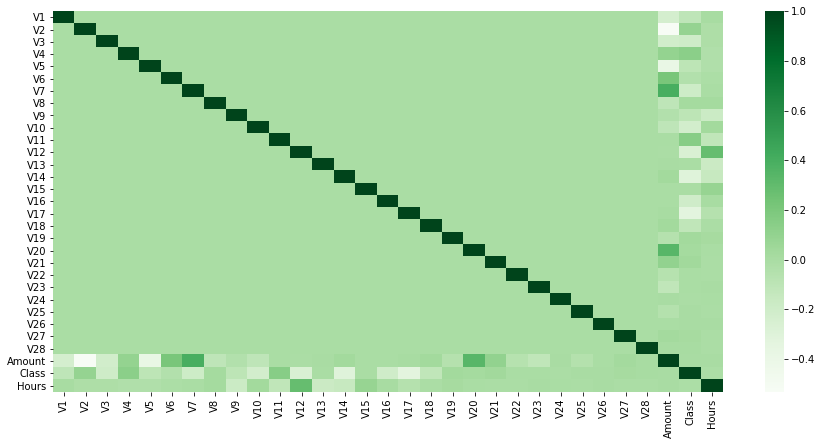

In [12]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(), cmap='Greens')
plt.show()

In [13]:
positive = df.query('Class==1')
negative = df.query('Class==0').sample(positive.shape[0])
merge = pd.concat([positive, negative])

In [51]:
def Generate_Param(param_grid):
    param_grid = OrderedDict(param_grid)
    params = list(product(*[param_grid[e] for e in param_grid]))
    for param in params:
        yield dict(zip(list(param_grid.keys()), param))

def RunClf(clf, X, y, scorer, params):
    clf = clf(**params)
    pred = clf.fit_predict(X)
    return params, scorer(y, pred), pred

def GetBest(output):
    max_score = 0
    best_param = None 
    best_preds = None
    for params, score, pred in output:
        if score > max_score: 
            max_score = score
            best_param = params
            best_preds = pred

    pprint.pprint(best_param)
    print(max_score)
    
    return max_score, best_param, best_preds

# Isolatin Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [47]:
param_grid_if = {'n_estimators': list(range(100, 800, 300)), 
                 'max_samples': list(range(100, 500, 200)), 
                 'contamination': [0.1, 0.5], 
                 'max_features': [1, 10], 
                 'bootstrap': [True, False],}

X_is = df.drop('Class', axis=1)
y_is = df['Class'].replace(1,-1).replace(0,1) 

RunClfPartial = partial(RunClf, IsolationForest, X_is, y_is, f1_score)
output = Parallel(n_jobs=cpu_count)(delayed(RunClfPartial)(i) for i in Generate_Param(param_grid))
max_score_is, best_param_is, best_preds_is = GetBest(output)

In [66]:
tn, fp, fn, tp  = confusion_matrix(df['Class'].replace(1,-1).replace(0,1), best_preds_is).ravel()

print('True Negative : ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive : ', tp)
print()
print('Precision :', (tp/(tp+fp)))
print('Recall    :', (tp/(tp+fn)))

True Negative :  437
False Positive:  55
False Negative:  28044
True Positive :  256271

Precision : 0.9997854294921311
Recall    : 0.9013629249248193


# Applying Polynomial Features

In [67]:
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
df_poly = poly.fit_transform(df.drop('Class', axis=1))
df_poly_names = poly.get_feature_names(df.drop('Class', axis=1).columns)
df_poly = pd.DataFrame(df_poly, columns=df_poly_names)

# Lgb Training Dataset

In [ ]:
X = df_poly
y = df['Class']

# LightGbm
## Hyperparameter Optimization

https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [ ]:
def LgbmGridSearch(X, y, param_grid, test_size=0.20):
    param_grid_product = list(product(*[param_grid[e] for e in param_grid]))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True, stratify=y)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test  = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    evals_result = dict()
    models = dict()
    
    index = 1
    for param in tqdm(param_grid_product):
        evals_result[f'Fit_{index}'] = {}

        tmp_param = {p:v for p, v in zip(param_grid.keys(), param)}

        tmp_param.update({'objective':'binary', 
                          'metric':'auc'})

        gbm = lgb.train(tmp_param, 
                        lgb_train, 
                        num_boost_round=1500, 
                        valid_sets=[lgb_train, lgb_test],
                        early_stopping_rounds=10, 
                        evals_result=evals_result[f'Fit_{index}'], 
                        verbose_eval=-1,)

        models[f'Fit_{index}'] = gbm
        index += 1
        
    with open(f'hyperopt.pickle', 'wb') as f:
        pickle.dump((evals_result, models), f)  
    return evals_result, models


param_grid ={
'boosting_type':['gbdt'], 
'num_leaves': [10, 15, 20],
'reg_alpha': [ 1e-1, 0, 1],
'reg_lambda': [1, 5, 10],
'learning_rate':[.0001],
'min_child_samples': [300], 
'min_child_weight': [1e-3, 1e-4],
'boost_from_average':[False],
'verbosity' : [-1],
'is_unbalance' : [True],
#'scale_pos_weight': [99]
            }

evals_result, models = LgbmGridSearch(X, y, param_grid)

sorted_evals_result = OrderedDict(sorted(evals_result.items(), key = lambda x: x[1]['valid_1']['auc'][-1]))
best_fit = list(sorted_evals_result.keys())[0]
best_params = models[best_fit].params
pprint.pprint(best_params)

# LightGbm
## Training with Crossvalidation

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

evals_result_train = dict()
models_train = dict()
preds = dict()
if 'learning_rate'  in best_params: best_params.pop('learning_rate')
if 'num_iterations' in best_params: best_params.pop('num_iterations')
    
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    evals_result_train[f'Fit_{fold}'] = {}
    
    X_train, X_test = X.loc[train_idx,:], X.loc[test_idx,:]
    y_train, y_test = y[train_idx], y[test_idx] 
    
    lgb_train = lgb.Dataset(X_train, y_train, weight=None, free_raw_data=False)
    lgb_eval  = lgb.Dataset(X_test, y_test,   weight=None, free_raw_data=False, reference=lgb_train)
    
    best_params.update({'early_stopping_round':5})
    
    gbm = lgb.train(best_params, 
                    lgb_train, 
                    num_boost_round=1000, 
                    valid_sets=[lgb_train, lgb_eval],
                    evals_result=evals_result_train[f'Fit_{fold}'], 
                    learning_rates=lambda x: 0.00001 * 0.9**x, # Applying Learning Rate Decay
                    verbose_eval=1,)
    
    preds[f'Fit_{fold}'] = [gbm.predict(X_test), y_test]
    models_train[f'Fit_{fold}'] = gbm

In [ ]:
output = pd.concat([pd.DataFrame([v[0].tolist(), v[1]]).T for k,v in preds.items()], axis=0).rename(columns={0:'y_Pred',1:'y_True'}).reset_index(drop=True)

# Results

In [ ]:
tn, fp, fn, tp  = confusion_matrix(output['y_True'], output['y_Pred'].round()).ravel()
print('True Negative : ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive : ', tp)
print()
print('Precision :', round((tp/(tp+fp)),2))
print('Recall    :', round((tp/(tp+fn)),2))

# Feature Importance

In [ ]:
avg_importance = np.array([v.feature_importance() for k, v in models_train.items()]).mean(axis=0)
feature_importance = pd.DataFrame({'Feature':df_poly_names,'Importance':avg_importance}).sort_values('Importance', ascending=False)
feature_importance.head(10).set_index('Feature').plot.bar()
plt.show()